# Sparkify Churn Prediction
-----
*Author : Ian Ho*

*Last Updated : 6 Aug 2020*

## Contents <a id="top">
* [0. Business Objective](#bizobj)
* [1. Setting Up](#setup)
* [2. Data Exploration / Preliminary Pre-processing](#dataexplore)
* [3. Feature Engineering](#feature)
* [4. Modelling](#model)
* [5. Value Proposition](#value)


## 0. Business Objective <a id="bizobj">
[back to top](#top)

### 0.1 Defining Churn

> **Customer churn** is a tendency of customers to abandon a brand and stop being a paying client of a particular business. The percentage of customers that discontinue using a company’s products or services during a particular time period is called a customer churn (attrition) rate.

For this project, we will define **churn** as when a user cancels the service. In the dataset, this is identified as having a value of ```Cancellation Confirmation``` under column ```page```.

### 0.2 Business Problem

Churn is a problem for Sparkify as it represents revenue lost from subscribers who leave the platform. There is revenue lost from subscribers who previously paid for the subscription. There is also revenue lost from free subscribers since there is less to be made through others revenue streams such as advertisement. 

Thus, the challenge is to identify these potential churn users before they actually cancel their subscription, and to employ appropriate countermeasure to prevent churn.

### 0.3 Solution Approach

In order to identify users who will potentially cancel their subscription, we will be attempting various machine learning techniques. These techniques will utilize data from past usage behaviour to identify the probability of a particular user eventually cancelling the subscription to Sparkify.

### 0.4 Post-Modelling Actionables

After we identify the potential churn users, Sparkfiy can use our predictions to take action against this potential churn. For example, our model could be re-run every day / week in order to identify potential churn users, and appropriate actions such as discounts / exclusive access could be offered on a personalized basis. What our model will **not** tell you is the exact actionable to be adopted. This will require further A/B testing in order to complement our identification strategy. 

## 1. Setting Up <a id="setup">
[back to top](#top)

### 1.1 Dependencies

In [112]:
import pandas as pd
import json
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from time import time

from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, \
                            confusion_matrix

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, from_unixtime, count, when, isnull, \
                                    date_format, year, month, dayofweek, \
                                    countDistinct, datediff, current_date, \
                                    min, max, avg, mean, stddev, skewness, kurtosis, \
                                    isnan, lit, hour
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, \
                        StandardScaler
from pyspark.sql.types import DateType, IntegerType, StringType
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, \
RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegressionModel, \
RandomForestClassificationModel, GBTClassificationModel, DecisionTreeClassificationModel

### 1.2 Defining paths / files

In [113]:
root_dir = '/Users/ianhojy/Desktop/DS_Assignment'
file_name = 'sparkify_data.json'

### 1.3 Instantiating spark session

In [114]:
spark = SparkSession \
    .builder \
    .appName("Sparkify Churn") \
    .getOrCreate()

### 1.4 Importing data

In [115]:
data = spark.read.json(os.path.join(root_dir, file_name))

#### 1.4.1 Schema

In [116]:
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



#### 1.4.2. Data Preview

In [117]:
data.show(5)

+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|           artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|              song|status|           ts|           userAgent|userId|
+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|    Martin Orford|Logged In|   Joseph|     M|           20| Morales|597.55057| free|  Corpus Christi, TX|   PUT|NextSong|1532063507000|      292|     Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|
|John Brown's Body|Logged In|   Sawyer|     M|           74|  Larson|380.21179| free|Houston-The Woodl...|   PUT|NextSong|1538069638000|    

## 2. Exploratory Data Analysis / Preliminary Pre-processing <a id="dataexplore">
[back to top](#top)

### 2.0 Overview

We create a view so that we can use SQL when more convenient

In [118]:
data.createOrReplaceTempView('data')

#### 2.0.1 Number of Observations

In [119]:
data.count()

543705

#### 2.0.2 Columns with null values

In [120]:
data.select([count(when(isnull(c), c)).alias(c) for c in data.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|  song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|110828|   0|    15700| 15700|            0|   15700|110828|    0|   15700|     0|   0|       15700|        0|110828|     0|  0|    15700|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+



#### 2.0.3 Categorical / Numerical Columns

In [121]:
numerical_cols = []
categorical_cols = []

for s in data.schema:
    data_type = str(s.dataType)
    if data_type == "StringType":
        categorical_cols.append(s.name)
    
    if data_type == "LongType" or data_type == "DoubleType":
        numerical_cols.append(s.name)

##### 2.0.3.1 Overview of Numerical Columns

In [122]:
for c in numerical_cols: 
    print("{} count: {}".format(c, data.select(c).count()))
    data.select([min(c), max(c), mean(c), stddev(c)]).show()

itemInSession count: 543705
+------------------+------------------+------------------+--------------------------+
|min(itemInSession)|max(itemInSession)|avg(itemInSession)|stddev_samp(itemInSession)|
+------------------+------------------+------------------+--------------------------+
|                 0|              1005|107.30629109535502|        116.72350849188119|
+------------------+------------------+------------------+--------------------------+

length count: 543705
+-----------+-----------+------------------+-------------------+
|min(length)|max(length)|       avg(length)|stddev_samp(length)|
+-----------+-----------+------------------+-------------------+
|    0.78322| 3024.66567|248.66459278007585|  98.41266955052022|
+-----------+-----------+------------------+-------------------+

registration count: 543705
+-----------------+-----------------+--------------------+-------------------------+
|min(registration)|max(registration)|   avg(registration)|stddev_samp(registration

In [123]:
for c in categorical_cols: 
    print("{} count: {}".format(c, data.select(c).count()))
    data.select(c).dropDuplicates().show()

artist count: 543705
+--------------------+
|              artist|
+--------------------+
|      The Black Keys|
|        Yann Tiersen|
|    Jane's Addiction|
|          Tim Hughes|
|Dashboard Confess...|
|                Silk|
|Yonder Mountain S...|
|            La Shica|
|        Elvis Crespo|
|         Silverstein|
|         Eva Cassidy|
|        Generation X|
|     Robyn Hitchcock|
|           Kate Nash|
|       Jupiter Jones|
|           Los Lobos|
|               Rufio|
|     Drive Like Jehu|
|       Yuichi Tamate|
|      Jarabe De Palo|
+--------------------+
only showing top 20 rows

auth count: 543705
+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+

firstName count: 543705
+---------+
|firstName|
+---------+
|   Maddox|
|    Lucas|
|   Karter|
|    Grace|
|    Irvin|
|  Janiyah|
| Antonina|
|    Allan|
|  Lorelei|
|    Devyn|
|    Bodhi|
|  Adriana|
| Isabella|
|  Everett|
|    James|
| Kamalani|
|    Wyatt|
|     Zola|
|

### 2.1 ```userId```
type: ```string```

#### 2.1.1 Drop rows with empty userId
Given the business objective, rows with missing ```userId``` will not be productive for the subsequent model

In [124]:
data = data.filter(data.userId!="")
data.count()

528005

These are probably users who are using the service as guests and are therefore not logged in.

We also check for na values in userId, for which there are none

In [125]:
data = data.dropna(how="any", subset=["userId"])
data.count()

528005

In [126]:
data.select([count(when(isnull(c), c)).alias(c) for c in data.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 95128|   0|        0|     0|            0|       0| 95128|    0|       0|     0|   0|           0|        0|95128|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



Great! It seems that null values in some columns like ```firstName```, ```lastName```, ```location```, ```gender``` are automatically resolved

What remains are the columns: ```artist```, ```length```, ```song```

#### 2.1.2 How many distinct users?

In [127]:
spark.sql('SELECT COUNT(DISTINCT userId) AS Number_Users FROM data').show()

+------------+
|Number_Users|
+------------+
|         449|
+------------+



### 2.2 ```sessionId```
type: ```long```

We also check for na values in userId, for which there are none

In [128]:
data = data.dropna(how="any", subset=["sessionId"])
data.count()

528005

### 2.3 ```page```
type: ```string```

#### 2.3.1 What are the unique page values?

In [129]:
data.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



#### 2.3.2 Preprocessing: Creating ```churn``` binary label

Since we want to identify users who hve confirmed the cancellation of the subscription, we use ```page == Cancellation Confirmation``` to first extract the relevant list of users, and subsequently create an additional column ```churn``` which will be a binary variable, where ```churn == true``` indicates confirmed cancellation. 

In [130]:
# obtain the unique userIds for those who confirmed cancellation
churn_users = data.filter(data.page=="Cancellation Confirmation").select("userId").dropDuplicates()

# extract these userIds into a list
churn_users = [(row['userId']) for row in churn_users.collect()]
print("{} churn users identified.".format(len(churn_users)))

# add an additional column to indicate churn
data = data.withColumn("churn", data.userId.isin(churn_users))

99 churn users identified.


### 2.4 ```gender```

#### 2.4.1 What is the gender distribution like for churn vs non-churn users?

In [131]:
churn_gender_count = data.dropDuplicates(['userId', 'gender']).groupby(['churn', 'gender']).count().sort('churn')
churn_gender_count.show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|false|     M|  196|
|false|     F|  153|
| true|     M|   54|
| true|     F|   45|
+-----+------+-----+



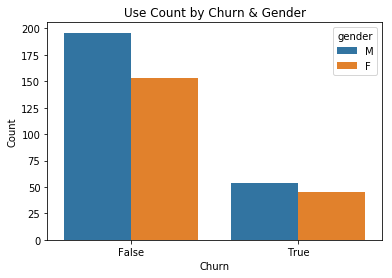

In [132]:
churn_gender_count_pd = churn_gender_count.toPandas()
sns.barplot(x='churn', y='count', hue='gender', data=churn_gender_count_pd)
plt.title('Use Count by Churn & Gender')
plt.ylabel('Count')
plt.xlabel('Churn')
plt.show()

### 2.5 ```ts``` (timestamp)

type: ```long```

#### 2.5.1 How does the timestamp data look like?

Note that the timestamp is in ```long``` type and needs to be converted to datetime

In [133]:
data.select('ts').show(3)

+-------------+
|           ts|
+-------------+
|1538352011000|
|1538352025000|
|1538352118000|
+-------------+
only showing top 3 rows



Assuming ```ts``` is a unix timestamp, we convert this to a ```date``` column with type ```DateType```

In [134]:
data = data.withColumn('date', from_unixtime((col('ts')/1000)).cast(DateType()))

In [135]:
data.select('date').show(3)

+----------+
|      date|
+----------+
|2018-10-01|
|2018-10-01|
|2018-10-01|
+----------+
only showing top 3 rows



#### 2.5.2 Preprocessing: Extracting year, month, day-of-week

In [136]:
data = data.withColumn('year', year(data.date))
data = data.withColumn('month', month(data.date))
data = data.withColumn('dayofweek', dayofweek(data.date))

In [137]:
data.select(['date', 'year', 'month', 'dayofweek']).show(1)

+----------+----+-----+---------+
|      date|year|month|dayofweek|
+----------+----+-----+---------+
|2018-10-01|2018|   10|        2|
+----------+----+-----+---------+
only showing top 1 row



In [138]:
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: boolean (nullable = true)
 |-- date: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- dayofweek: integer (nullable = true)



### 2.6 ```level```
type: ```string```

#### 2.6.1 Distribution of user behaviour by churn and level

In [139]:
churn_level_count = data.groupBy(['churn', 'level']).count()
churn_level_count.show()

+-----+-----+------+
|churn|level| count|
+-----+-----+------+
|false| free| 82467|
|false| paid|341892|
| true| paid| 76152|
| true| free| 27494|
+-----+-----+------+



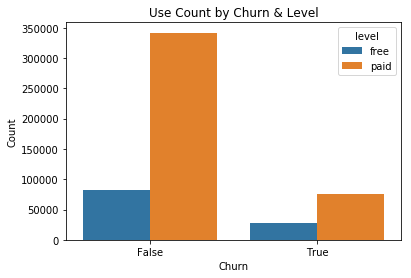

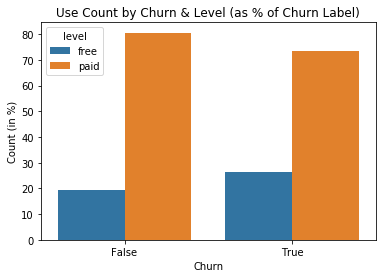

In [140]:
churn_level_count_pd = churn_level_count.toPandas()
sns.barplot(x='churn', y='count', hue='level', data=churn_level_count_pd)
plt.title('Use Count by Churn & Level')
plt.ylabel('Count')
plt.xlabel('Churn')
plt.show()

churn_sum = churn_level_count_pd.groupby('churn', as_index=False).sum()
churn_level_count_pd['proportion'] = (churn_level_count_pd.join(churn_sum, on = 'churn', lsuffix='_1')['count_1']/churn_level_count_pd.join(churn_sum, on = 'churn', lsuffix='_1')['count'])*100
sns.barplot(x='churn', y='proportion', hue='level', data=churn_level_count_pd)
plt.title('Use Count by Churn & Level (as % of Churn Label)')
plt.ylabel('Count (in %)')
plt.xlabel('Churn')
plt.show()

### 2.7 ```length```
type: ```double```

In [141]:
data.groupBy('churn').avg('length').show(5)

+-----+------------------+
|churn|       avg(length)|
+-----+------------------+
| true|248.99398360601631|
|false|248.58486352452456|
+-----+------------------+



### 2.8 ```auth```
type: ```string```

In [142]:
data.groupBy('auth').count().show()

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    99|
|Logged In|527906|
+---------+------+



In [143]:
data.groupby(['auth', 'churn']).count().show()

+---------+-----+------+
|     auth|churn| count|
+---------+-----+------+
|Cancelled| true|    99|
|Logged In| true|103547|
|Logged In|false|424359|
+---------+-----+------+



Great! Seems like our churn identification has a one-one matching with that in ```auth```. Therefore, we drop the auth column as a predictor variable.

In [144]:
data = data.drop('auth')

### 2.9 ```location```
type: ```string```

#### 2.9.1 Number of Unique Locations

In [145]:
spark.sql("SELECT COUNT(DISTINCT location) FROM data").show()

+------------------------+
|count(DISTINCT location)|
+------------------------+
|                     192|
+------------------------+



### 2.10 ```method```
type: ```string```

In [146]:
data.groupBy('method').count().show()

+------+------+
|method| count|
+------+------+
|   PUT|489128|
|   GET| 38877|
+------+------+



In [147]:
data.groupBy('page').count().show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    99|
|    Submit Downgrade|   117|
|         Thumbs Down|  4911|
|                Home| 19089|
|           Downgrade|  3811|
|         Roll Advert|  7773|
|              Logout|  5990|
|       Save Settings|   585|
|Cancellation Conf...|    99|
|               About|  1026|
|            Settings|  2964|
|     Add to Playlist| 12349|
|          Add Friend|  8087|
|            NextSong|432877|
|           Thumbs Up| 23826|
|                Help|  2644|
|             Upgrade|   968|
|               Error|   503|
|      Submit Upgrade|   287|
+--------------------+------+



### 2.11 ```registration```
type: long

#### 2.11.1 Convert from unix time

In [148]:
data = data.withColumn('reg_date', from_unixtime((col('registration')/1000)).cast(DateType()))

### 2.12 ```userAgent```
type: string

In [149]:
data.groupBy('userAgent').count().show()

+--------------------+-----+
|           userAgent|count|
+--------------------+-----+
|"Mozilla/5.0 (Mac...| 2050|
|"Mozilla/5.0 (Win...| 3576|
|Mozilla/5.0 (X11;...| 1897|
|"Mozilla/5.0 (Mac...|46082|
|"Mozilla/5.0 (Mac...| 2416|
|Mozilla/5.0 (Maci...| 2034|
|Mozilla/5.0 (Wind...| 9735|
|Mozilla/5.0 (Wind...|12874|
|Mozilla/5.0 (comp...|10301|
|"Mozilla/5.0 (Win...|14350|
|Mozilla/5.0 (Maci...|16137|
|"Mozilla/5.0 (Mac...| 5711|
|Mozilla/5.0 (Wind...| 1123|
|"Mozilla/5.0 (Win...| 1982|
|"Mozilla/5.0 (iPh...| 1803|
|"Mozilla/5.0 (Win...|31702|
|Mozilla/5.0 (Wind...|39456|
|"Mozilla/5.0 (Mac...|  896|
|Mozilla/5.0 (Wind...| 5988|
|Mozilla/5.0 (Maci...|  447|
+--------------------+-----+
only showing top 20 rows



### 2.13 Further Exploration

#### 2.13.1 Time-trend of user count according to churn status

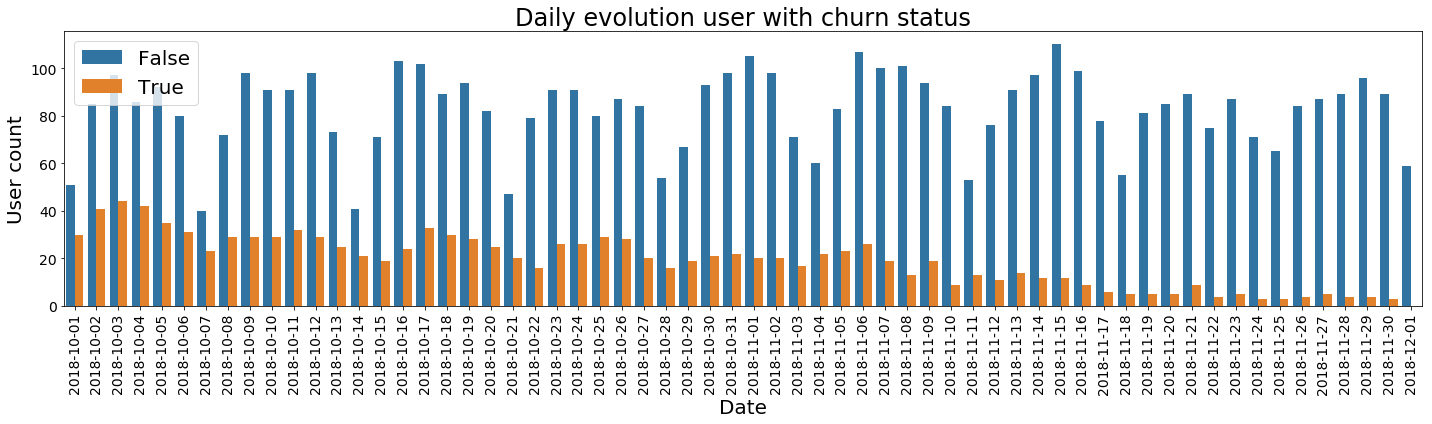

In [150]:
data_daily_user_churn = data.dropDuplicates(['userId', 'date'])\
                    .groupby(['date', 'churn'])\
                    .count()\
                    .sort('date')\
                    .toPandas()

fig = plt.figure(figsize=(20, 6))
sns.barplot(x='date', y='count', hue='churn', data=data_daily_user_churn)
plt.title("Daily evolution user with churn status", fontsize=24)
plt.xlabel("Date", fontsize=20)
plt.ylabel("User count", fontsize=20)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()

#### 2.13.2 Time-trend of user count according to level status

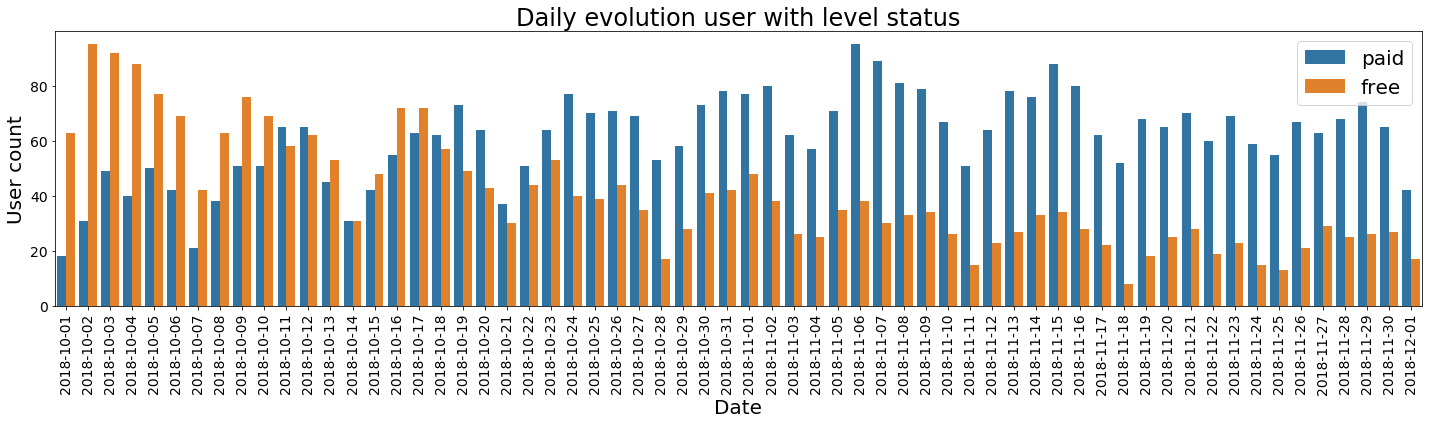

In [151]:
data_daily_user_level = data.dropDuplicates(['userId', 'date'])\
                    .groupby(['date', 'level'])\
                    .count()\
                    .sort('date')\
                    .toPandas()

fig = plt.figure(figsize=(20, 6))
sns.barplot(x='date', y='count', hue='level', data=data_daily_user_level)
plt.title("Daily evolution user with level status", fontsize=24)
plt.xlabel("Date", fontsize=20)
plt.ylabel("User count", fontsize=20)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=20)
plt.tight_layout()
plt.show()

**Observation**: It would appear that there is significant conversion form free to paid users

#### 2.13.3 Time of Day Activity

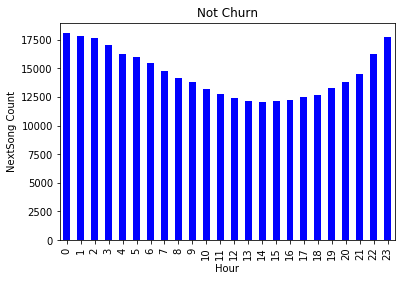

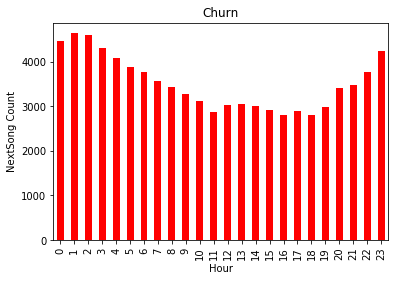

In [155]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
data = data.withColumn("hour", get_hour(data.ts))

hourly_data = data.filter(data.page == "NextSong").groupby("churn", "hour")\
                .count().orderBy(data["hour"].cast("float")).toPandas()
hourly_data["hour"] = pd.to_numeric(hourly_data["hour"])

hourly_data[hourly_data["churn"]==0].plot.bar(x='hour', y='count', color='Blue')
plt.ylabel('NextSong Count')
plt.xlabel('Hour')
plt.title('Not Churn')
plt.gca().get_legend().remove()
plt.show()

hourly_data[hourly_data["churn"]==1].plot.bar(x='hour', y='count', color='Red')
plt.ylabel('NextSong Count')
plt.xlabel('Hour')
plt.title('Churn')
plt.gca().get_legend().remove()
plt.show()

#### 2.13.4 User by Location

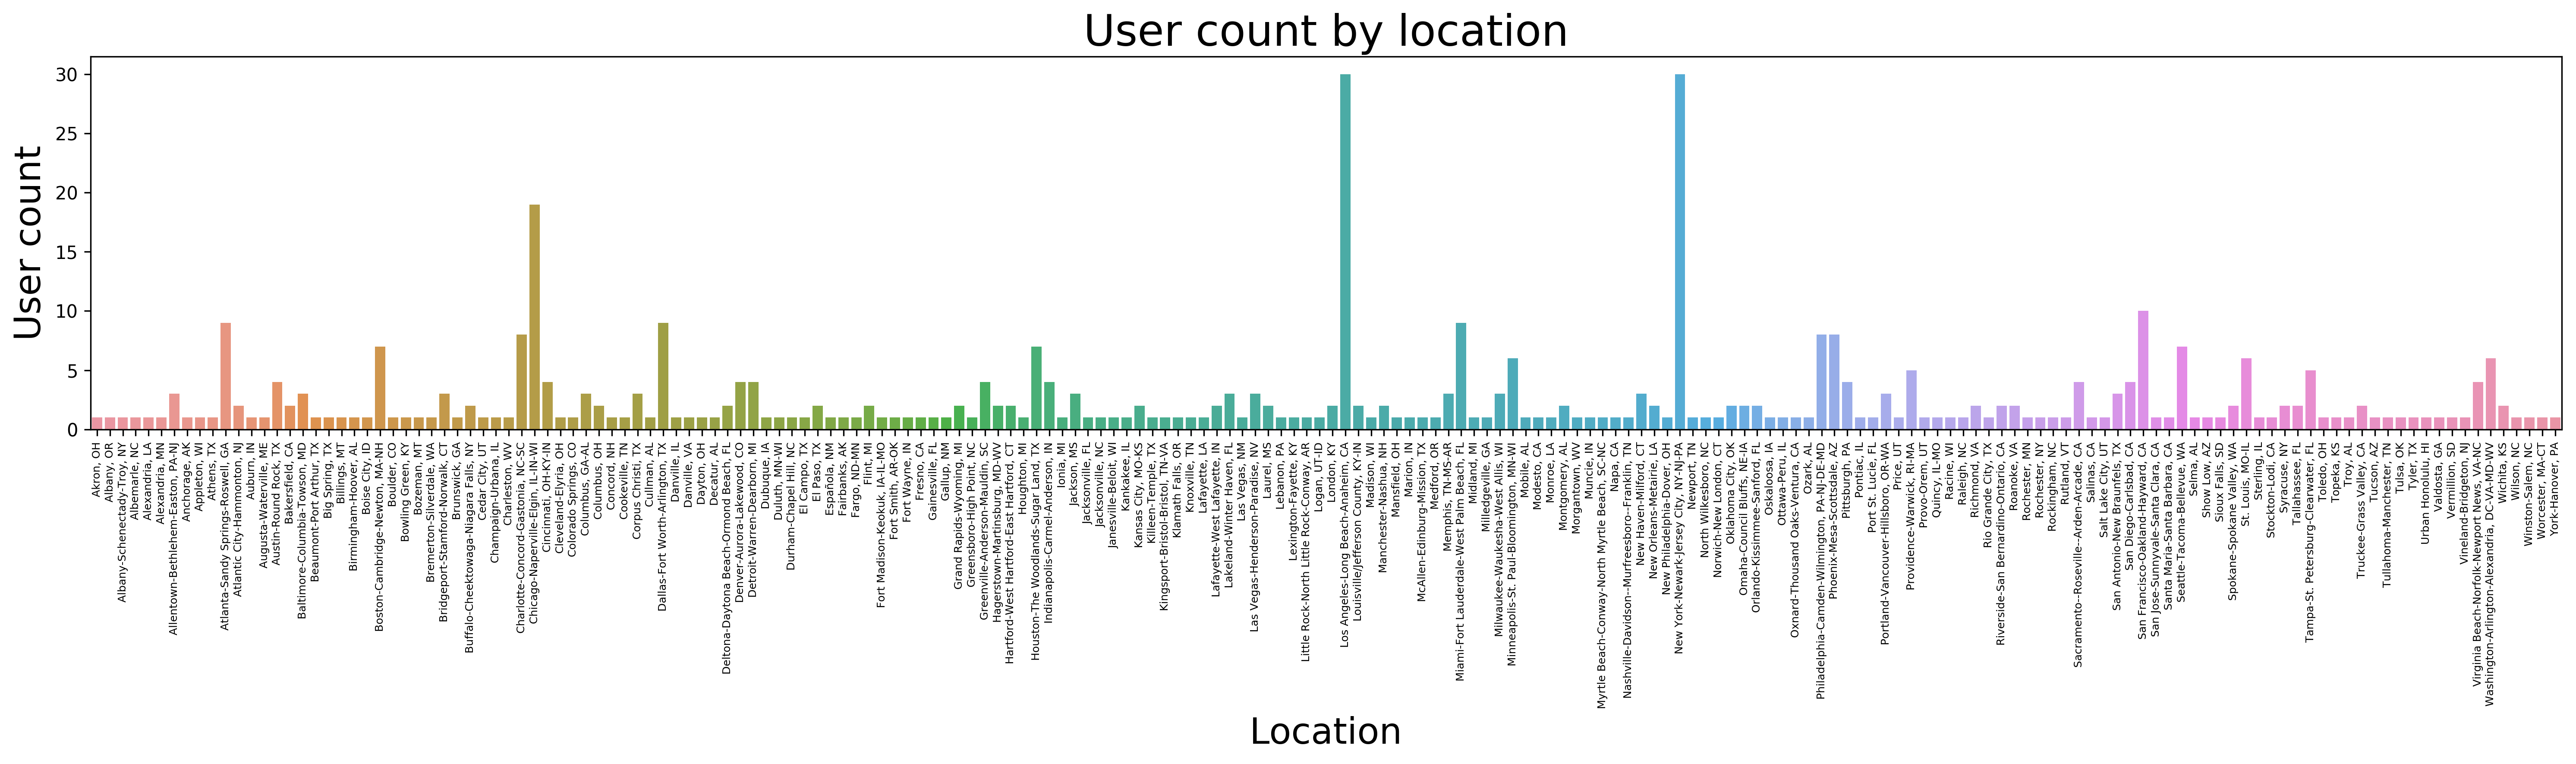

In [156]:
location_data = data.dropDuplicates(["userId", "location"]).groupby(["location"]).count().sort("location").toPandas()
fig = plt.figure(figsize=(20, 6), dpi=300)
sns.barplot(x='location', y='count', data=location_data)
plt.title("User count by location", fontsize=24)
plt.xlabel("Location", fontsize=20)
plt.ylabel("User count", fontsize=20)
plt.xticks(rotation=90, fontsize=6)
plt.tight_layout()
plt.show()

In [161]:
location_data.sort_values('count', ascending=False).head(10)

,location,count
97,"Los Angeles-Long Beach-Anaheim, CA",30
123,"New York-Newark-Jersey City, NY-NJ-PA",30
34,"Chicago-Naperville-Elgin, IL-IN-WI",19
159,"San Francisco-Oakland-Hayward, CA",10
44,"Dallas-Fort Worth-Arlington, TX",9
106,"Miami-Fort Lauderdale-West Palm Beach, FL",9
10,"Atlanta-Sandy Springs-Roswell, GA",9
33,"Charlotte-Concord-Gastonia, NC-SC",8
135,"Phoenix-Mesa-Scottsdale, AZ",8
134,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",8


## 3. Feature Engineering <a id="feature">
[back to top](#top)

### 3.1 Converting ```churn``` from boolean to integer

In [164]:
bool_to_int = udf(lambda x: 1 if x==True else 0)
data = data.withColumn('churn', bool_to_int('churn'))

### 3.2 Time-based features


#### 3.2.1 Average number of distinct sessions per day and per month

In [165]:
day_data = data.groupby(['userId', 'date'])\
                .agg(countDistinct('sessionId'))\
                .groupBy('userId')\
                .avg('count(sessionId)')\
                .withColumnRenamed('avg(count(sessionId))', 'daily_sessions')

In [166]:
month_data = data.groupby(['userId', 'month'])\
                .agg(countDistinct('sessionId'))\
                .groupBy('userId')\
                .avg('count(sessionId)')\
                .withColumnRenamed('avg(count(sessionId))', 'monthly_sessions')

In [167]:
day_data_churn = day_data.withColumn("churn", day_data.userId.isin(churn_users))
day_data_churn.groupBy('churn').avg('daily_sessions').show()

+-----+-------------------+
|churn|avg(daily_sessions)|
+-----+-------------------+
| true| 1.1990416287391599|
|false| 1.1144163677956678|
+-----+-------------------+



In [168]:
month_data_churn = month_data.withColumn("churn", month_data.userId.isin(churn_users))
month_data_churn.groupBy('churn').avg('monthly_sessions').show()

+-----+---------------------+
|churn|avg(monthly_sessions)|
+-----+---------------------+
| true|    7.656565656565657|
|false|    6.499044890162368|
+-----+---------------------+



#### 3.2.2 Average number of songs per day and per month

In [169]:
day_song_data = data.groupby(['userId', 'date'])\
                .agg(count('song'))\
                .groupBy('userId')\
                .avg('count(song)')\
                .withColumnRenamed('avg(count(song))', 'daily_songs')

In [170]:
month_song_data = data.groupby(['userId', 'month'])\
                .agg(count('song'))\
                .groupBy('userId')\
                .avg('count(song)')\
                .withColumnRenamed('avg(count(song))', 'monthly_songs')

In [171]:
day_song_data_churn = day_song_data.withColumn("churn", day_song_data.userId.isin(churn_users))
day_song_data_churn.groupBy('churn').avg('daily_songs').show()

+-----+------------------+
|churn|  avg(daily_songs)|
+-----+------------------+
| true|  64.0438164971714|
|false|55.178786899500345|
+-----+------------------+



In [172]:
month_song_data_churn = month_song_data.withColumn("churn", month_song_data.userId.isin(churn_users))
month_song_data_churn.groupBy('churn').avg('monthly_songs').show()

+-----+------------------+
|churn|avg(monthly_songs)|
+-----+------------------+
| true| 513.2474747474747|
|false| 452.6647564469914|
+-----+------------------+



#### 3.2.3 Number of days since registration

In [173]:
data = data.withColumn('days_since_registration', datediff(current_date(), col('reg_date')))

In [174]:
days_since_reg = data \
    .select('userId', 'days_since_registration') \
    .dropDuplicates() 

days_since_reg.describe().show()

+-------+------------------+-----------------------+
|summary|            userId|days_since_registration|
+-------+------------------+-----------------------+
|  count|               448|                    448|
|   mean| 67520.34821428571|      740.0982142857143|
| stddev|105964.58428485184|      37.60431214775913|
|    min|                10|                    651|
|    max|                99|                   1035|
+-------+------------------+-----------------------+



### 3.3 Other Features

#### 3.3.1 Gender

In [175]:
gender = data \
    .select("userId", "gender") \
    .dropDuplicates() \
    .replace(['M', 'F'], ['0', '1'], 'gender') \
    .select('userId', col('gender').cast('int')) \
    .orderBy("userId")

gender.show(5)
gender.describe().show()

+------+------+
|userId|gender|
+------+------+
|    10|     0|
|   100|     0|
|100001|     1|
|100002|     1|
|100003|     1|
+------+------+
only showing top 5 rows

+-------+-----------------+------------------+
|summary|           userId|            gender|
+-------+-----------------+------------------+
|  count|              448|               448|
|   mean|67520.34821428571|0.4419642857142857|
| stddev|105964.5842848519|0.4971756279079038|
|    min|               10|                 0|
|    max|               99|                 1|
+-------+-----------------+------------------+



#### 3.3.2 Paid
Whether a particular has ever paid for an account. Can further trial with alternative definitions of paid, such as whether the user has gone from paid to non-paid before etc.

In [176]:
paid = data.groupBy('userId')\
    .agg(max('level'))\
    .replace(['free', 'paid'], ['0', '1'], 'max(level)')\
    .select('userId', col('max(level)').cast('int'))\
    .withColumnRenamed('max(level)', 'paid')
    
paid.show(5)
paid.describe().show()

+------+----+
|userId|paid|
+------+----+
|100010|   0|
|200002|   1|
|   296|   1|
|   125|   0|
|   124|   1|
+------+----+
only showing top 5 rows

+-------+------------------+------------------+
|summary|            userId|              paid|
+-------+------------------+------------------+
|  count|               448|               448|
|   mean| 67520.34821428571|0.7165178571428571|
| stddev|105964.58428485192|0.4511922259263091|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



#### 3.3.3 Number of Artists listened to

In [177]:
num_artists = data \
    .filter(data.page=="NextSong") \
    .select("userId", "artist") \
    .dropDuplicates() \
    .groupby("userId") \
    .count() \
    .withColumnRenamed("count", "num_artist") \
    .orderBy("userId")

num_artists.describe().show()

+-------+-----------------+-----------------+
|summary|           userId|       num_artist|
+-------+-----------------+-----------------+
|  count|              448|              448|
|   mean|67520.34821428571|658.9799107142857|
| stddev|105964.5842848519| 625.882698051957|
|    min|               10|                1|
|    max|               99|             3507|
+-------+-----------------+-----------------+



#### 3.3.4 Number of friends

In [178]:
num_friends = data \
    .select('userID','page') \
    .where(data.page == 'Add Friend') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'num_friend') \
    .orderBy("userId")

num_friends.describe().show()

+-------+------------------+------------------+
|summary|            userID|        num_friend|
+-------+------------------+------------------+
|  count|               409|               409|
|   mean|  66368.3716381418|19.772616136919314|
| stddev|106064.01609030597| 22.49443576627283|
|    min|                10|                 1|
|    max|                99|               158|
+-------+------------------+------------------+



#### 3.3.5 Number of thumbs down

In [179]:
num_thumbs_down = data \
    .select('userID','page') \
    .where(data.page == 'Thumbs Down') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'num_thumbs_down') \
    .orderBy("userId")

num_thumbs_down.describe().show()

+-------+------------------+------------------+
|summary|            userID|   num_thumbs_down|
+-------+------------------+------------------+
|  count|               389|               389|
|   mean| 70031.19537275065|12.624678663239074|
| stddev|106895.73735311364| 13.58243285193799|
|    min|                10|                 1|
|    max|                99|                80|
+-------+------------------+------------------+



#### 3.3.6 Number of thumbs up

In [180]:
num_thumbs_up = data \
    .select('userID','page') \
    .where(data.page == 'Thumbs Up') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'num_thumbs_up') \
    .orderBy("userId")

num_thumbs_up.describe().show()

+-------+-----------------+-----------------+
|summary|           userID|    num_thumbs_up|
+-------+-----------------+-----------------+
|  count|              439|              439|
|   mean|67308.81548974942|54.27334851936219|
| stddev|106228.8040825479|69.94135178778983|
|    min|               10|                1|
|    max|               99|              506|
+-------+-----------------+-----------------+



#### 3.3.7 Number of songs added to playlist

In [181]:
num_add_playlist = data \
    .select('userID','page') \
    .where(data.page == 'Add to Playlist') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'num_add_playlist') \
    .orderBy("userId")

num_add_playlist.describe().show()

+-------+------------------+------------------+
|summary|            userID|  num_add_playlist|
+-------+------------------+------------------+
|  count|               428|               428|
|   mean| 65764.93457943926|28.852803738317757|
| stddev|105363.38578382804|33.913090694566286|
|    min|                10|                 1|
|    max|                99|               248|
+-------+------------------+------------------+



#### 3.3.8 Number of downgrades

In [182]:
downgrade = data \
    .select('userID','page') \
    .where(data.page == 'Downgrade') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'downgrade') \
    .orderBy("userId")

downgrade.describe().show()

+-------+------------------+------------------+
|summary|            userID|         downgrade|
+-------+------------------+------------------+
|  count|               301|               301|
|   mean| 69214.00332225913|12.661129568106313|
| stddev|109835.16929944001|12.522970256818315|
|    min|                10|                 1|
|    max|                99|                85|
+-------+------------------+------------------+



#### 3.3.9 Number of upgrades

In [183]:
upgrade = data \
    .select('userID','page') \
    .where(data.page == 'Upgrade') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'upgrade') \
    .orderBy("userId")

upgrade.describe().show()

+-------+------------------+------------------+
|summary|            userID|           upgrade|
+-------+------------------+------------------+
|  count|               315|               315|
|   mean|62333.184126984124| 3.073015873015873|
| stddev|100904.14441579921|2.5271271136988402|
|    min|               100|                 1|
|    max|                99|                16|
+-------+------------------+------------------+



#### 3.3.8 Average session time 

In [184]:
sesstime = data.groupBy(["userId", "sessionId"]) \
                .agg(((max(data.ts)-min(data.ts))/(1000*60))
                .alias("sessTime"))

avgtime = sesstime.groupby("userId") \
                    .agg(avg(sesstime.sessTime).alias("avgSessTime")) \
                    .orderBy("userId")

avgtime.describe().show()

+-------+-----------------+------------------+
|summary|           userId|       avgSessTime|
+-------+-----------------+------------------+
|  count|              448|               448|
|   mean|67520.34821428571|   267.78884543676|
| stddev|105964.5842848519| 164.3624010530248|
|    min|               10|13.166666666666666|
|    max|               99|            1502.4|
+-------+-----------------+------------------+



### 3.4 Final dataset 

In [185]:
final_data = data.select('userId', 'churn').dropDuplicates()
final_data.show(5)

+------+-----+
|userId|churn|
+------+-----+
|    26|    0|
|200011|    0|
|   277|    0|
|300001|    0|
|   165|    0|
+------+-----+
only showing top 5 rows



In [186]:
final_data = final_data.join(gender, 'userId', 'left') \
                .join(paid, 'userId', 'left') \
                .join(day_data, 'userId', 'left') \
                .join(month_data, 'userId', 'left') \
                .join(day_song_data, 'userId', 'left') \
                .join(month_song_data, 'userId', 'left') \
                .join(days_since_reg, 'userId', 'left')

In [187]:
final_data = final_data.join(num_artists, 'userId', 'outer') \
                .join(num_friends, 'userId', 'outer') \
                .join(num_thumbs_down, 'userId', 'outer') \
                .join(num_thumbs_up, 'userId', 'outer') \
                .join(num_add_playlist, 'userId', 'outer') \
                .join(avgtime, 'userId', 'left') \
                .join(upgrade, 'userId', 'left') \
                .join(downgrade, 'userId', 'left') 

In [188]:
final_data = final_data.drop('userId').fillna(0)

#### 3.4.1 Save data in csv format

In [189]:
data_outpath = 'sparkify_clean.csv'
final_data.toPandas().to_csv(data_outpath)

## 4. Modelling <a id="model">
[back to top](#top)


### 4.1 Processing Pipeline

In [238]:
dataset = spark.read.csv(data_outpath, header=True)
dataset.persist()
dataset.show(5)

+---+-----+------+----+------------------+----------------+------------------+-------------+-----------------------+----------+----------+---------------+-------------+----------------+------------------+-------+---------+
|_c0|churn|gender|paid|    daily_sessions|monthly_sessions|       daily_songs|monthly_songs|days_since_registration|num_artist|num_friend|num_thumbs_down|num_thumbs_up|num_add_playlist|       avgSessTime|upgrade|downgrade|
+---+-----+------+----+------------------+----------------+------------------+-------------+-----------------------+----------+----------+---------------+-------------+----------------+------------------+-------+---------+
|  0|    1|     1|   0|               1.0|             2.0|              48.0|         96.0|                    709|        94|         3|              3|            4|               1|           210.375|      2|        0|
|  1|    1|     0|   1|               1.0|             5.0|51.666666666666664|        310.0|                

In [239]:
# Dropping the index column
dataset = dataset.drop('_c0')

# Relabelling the y variable
dataset = dataset.withColumnRenamed('churn', 'label')

print('Count by label:')
dataset.groupby('label').count().show()

Count by label:
+-----+-----+
|label|count|
+-----+-----+
|    0|  349|
|    1|   99|
+-----+-----+



#### 4.1.1 Procesing the categorical and numerical columns

In [240]:
numericCols = ['daily_sessions', 'monthly_sessions',
               'daily_songs', 'monthly_songs', 'days_since_registration', 'num_artist',
               'num_friend', 'num_thumbs_down', 'num_thumbs_up', 'num_add_playlist',
               'avgSessTime', 'upgrade', 'downgrade']

# casting numerical columns to float datatype
for col_name in numericCols:
    dataset = dataset.withColumn(col_name, col(col_name).cast('float'))
    
dataset = dataset.withColumn('label', col('label').cast('float'))

# one hot encoding categorical columns
cat_cols = ['gender']
for c in cat_cols:
    indexer = StringIndexer(inputCol=c, outputCol=c+'_index')
    dataset = indexer.fit(dataset).transform(dataset)
    
OHE = OneHotEncoder(inputCols=[c+'_index' for c in cat_cols], 
                            outputCols=[c+'_OHE' for c in cat_cols])

dataset = OHE.fit(dataset).transform(dataset)

# standard-scaling the numerical columns
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in numericCols]
scalers = [StandardScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in numericCols]
pipeline = Pipeline(stages=assemblers + scalers)

scalerModel = pipeline.fit(dataset)
final_dataset = scalerModel.transform(dataset)

cols = [c for c in final_dataset.columns if 'scale' in c]
final_assembler = VectorAssembler(inputCols=cols, outputCol='features')
final_dataset = final_assembler.transform(final_dataset)


#### 4.1.2 Stratified train-test split

In [241]:
seed = 42
frac = 0.8

In [242]:
fractions = final_dataset.select("label").distinct().withColumn("fraction", lit(frac)).rdd.collectAsMap()

train = final_dataset.stat.sampleBy("label", fractions, seed)
test = final_dataset.subtract(train)

final_dataset.groupBy('label').count().show()
train.groupBy('label').count().show()
test.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   99|
|  0.0|  349|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   85|
|  0.0|  298|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   14|
|  0.0|   51|
+-----+-----+



#### 4.1.3 Churn class Up-Sampling

In [243]:
upsample_ratio = 0.5

In [244]:
train_churn = train.where(col('label')==1).sample(True, train.where(col('label')==0).count()/train.where(col('label')==1).count() * upsample_ratio)
train_no_churn = train.where(col('label')==0)
train = train_churn.unionAll(train_no_churn)
train.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|  149|
|  0.0|  298|
+-----+-----+



### 4.2 Modelling

#### 4.2.1 UDFs for training and evaluation

I will be using 3-fold CV to choose the best parameters for each model. The reason for using CV is because of the relative small number of data points. This will be executed by ```train_model```. Subsequently, ```eval_model``` will provide preliminary evaluation metrics for each model. Finally ```plot_feature_importance``` will load the best saved model and display the ranks of feature importance for each model.

```python

def eval_model(model, data):
    """
    Function for evaluating trained model using test data

    Parameters
    ----------
    model : object
        trained model
    data : spark Dataframe
        test data to be evaluated

    Returns
    -------
    summary: spark Dataframe
        contains evaluation metrics

    """
    pred = model.transform(data)

    evaluator = MulticlassClassificationEvaluator()

    evalMetrics = {}
    evalMetrics["precision"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedPrecision"})
    evalMetrics["recall"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedRecall"})
    evalMetrics["f1"] = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
    evalMetrics["accuracy"] = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})

    # Build a Spark dataframe from the metrics
    metrics_to_display = {
        k:round(v, 4) for k,v in evalMetrics.items() if ('confusion_matrix' not in k)
    }
    summary = spark.createDataFrame(pd.DataFrame([metrics_to_display], columns=metrics_to_display.keys()))

    return summary

def train_model(train, estimator, paramGrid, folds=3):
    """
    Fits estimator with training data and tunes using given grid with 3 folds

    Parameters
    ----------
    train : spark DataFrame
        training data
    estimator : object
        model class
    paramGrid : object
        built parameter grid object

    Returns
    -------
    model : object
        trained model with best parameters
    """
    crossval = CrossValidator(estimator=estimator,
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(),
                              numFolds=folds)

    model = crossval.fit(train)

    return model


def plot_feature_importance(model, feature_cols, clf):
    """
    Plots bar chart showing feature importance

    Parameters
    ----------
    model : object
        trained model
    feature_cols : list
        list of columns in dataset
    clf : string
        estimator name

    """

    if clf == 'LogisticRegression':
        feature_coef = model.coefficients.values.tolist()
        feature_coef_df = pd.DataFrame(list(zip(feature_cols, feature_coef)), columns=['Feature', 'Coefficient'])\
        .sort_values('Coefficient', ascending=False)

    else:
        feature_ind = model.featureImportances.indices.tolist()
        feature_name = [feature_cols[ind] for ind in feature_ind]
        feature_coef = model.featureImportances.values.tolist()
        feature_coef_df = pd.DataFrame(list(zip(feature_name, feature_coef)), columns=['Feature', 'Coefficient'])\
            .sort_values('Coefficient', ascending=False)

    plt.figure(figsize=(20,8))
    sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
    plt.title('Feature importance for {}'.format(clf), fontsize=20)
    plt.xlabel('Features', fontsize=17)
    plt.ylabel('Coefficient', fontsize=17)
    plt.xticks(rotation=45, ha='right', fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.show()

```

#### 4.2.2 Defining Models & Search-space

We will be looking at four machine learning algorithms with the following hyperparameter configurations:
- <u>Logistic Regression</u>
    - ElasticNet Parameter : (0, 0.1, 0.5, 1.0)
    - Regularization Parameter : (0, 0.05, 0.1)
    
    
- <u>Decision Tree Classifier</u>
    - Impurity : (Entropy, Gini)
    - Max Depth : (2, 4, 6, 8)
    
    
- <u>Gradient Boosted Tree Classifier</u>
    - Max Iterations : (10, 20, 30)
    - Max Bins : (20, 40, 60)
    - Max Depth : (2, 4, 6, 8, 10)
    
    
- <u>Random Forest Classifier</u>
    - Impurity :  (Entropy, Gini)
    - Max Depth : (2, 4, 6, 8)

In [266]:
def eval_model(model, data):
    """
    Function for evaluating trained model using test data

    Parameters
    ----------
    model : object
        trained model
    data : spark Dataframe
        test data to be evaluated

    Returns
    -------
    summary: spark Dataframe
        contains evaluation metrics

    """
    pred = model.transform(data)

    evaluator = MulticlassClassificationEvaluator()

    evalMetrics = {}
    evalMetrics["precision"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedPrecision"})
    evalMetrics["recall"] = evaluator.evaluate(pred, {evaluator.metricName: "weightedRecall"})
    evalMetrics["f1"] = evaluator.evaluate(pred, {evaluator.metricName: "f1"})
    evalMetrics["accuracy"] = evaluator.evaluate(pred, {evaluator.metricName: "accuracy"})

    # Build a Spark dataframe from the metrics
    metrics_to_display = {
        k:round(v, 4) for k,v in evalMetrics.items() if ('confusion_matrix' not in k)
    }
    summary = spark.createDataFrame(pd.DataFrame([metrics_to_display], columns=metrics_to_display.keys()))

    return summary

def train_model(train, estimator, paramGrid, folds=3):
    """
    Fits estimator with training data and tunes using given grid with 3 folds

    Parameters
    ----------
    train : spark DataFrame
        training data
    estimator : object
        model class
    paramGrid : object
        built parameter grid object

    Returns
    -------
    model : object
        trained model with best parameters
    """
    crossval = CrossValidator(estimator=estimator,
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(),
                              numFolds=folds)

    model = crossval.fit(train)

    return model


def plot_feature_importance(model, feature_cols, clf):
    """
    Plots bar chart showing feature importance

    Parameters
    ----------
    model : object
        trained model
    feature_cols : list
        list of columns in dataset
    clf : string
        estimator name

    """

    if clf == 'LogisticRegression':
        feature_coef = model.coefficients.values.tolist()
        feature_coef_df = pd.DataFrame(list(zip(feature_cols, feature_coef)), columns=['Feature', 'Coefficient'])\
        .sort_values('Coefficient', ascending=False)

    else:
        feature_ind = model.featureImportances.indices.tolist()
        feature_name = [feature_cols[ind] for ind in feature_ind]
        feature_coef = model.featureImportances.values.tolist()
        feature_coef_df = pd.DataFrame(list(zip(feature_name, feature_coef)), columns=['Feature', 'Coefficient'])\
            .sort_values('Coefficient', ascending=False)

    plt.figure(figsize=(20,8))
    sns.barplot(x='Feature', y='Coefficient', data=feature_coef_df)
    plt.title('Feature importance for {}'.format(clf), fontsize=20)
    plt.xlabel('Features', fontsize=17)
    plt.ylabel('Coefficient', fontsize=17)
    plt.xticks(rotation=45, ha='right', fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.show()


In [267]:
lr =  LogisticRegression(labelCol="label", featuresCol="features")
paramGrid_lr = ParamGridBuilder()\
    .addGrid(lr.elasticNetParam,[0.0, 0.1, 0.5, 1.0]) \
    .addGrid(lr.regParam,[0.0, 0.05, 0.1]) \
    .build()

dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
paramGrid_dt = ParamGridBuilder()\
    .addGrid(dt.impurity,['entropy', 'gini']) \
    .addGrid(dt.maxDepth,[2, 4, 6, 8]) \
    .build()

gbt = GBTClassifier(labelCol="label", featuresCol="features")
paramGrid_gbt = ParamGridBuilder()\
    .addGrid(gbt.maxIter,[10, 20, 30])\
    .addGrid(gbt.maxBins, [20, 40, 60])\
    .addGrid(gbt.maxDepth,[2, 4, 6, 8, 10]) \
    .build()

rf = RandomForestClassifier(labelCol="label", featuresCol="features")
paramGrid_rf = ParamGridBuilder()\
    .addGrid(rf.impurity,['entropy', 'gini']) \
    .addGrid(rf.maxDepth,[2, 4, 6, 8]) \
    .build()

estimator_name = ['LogisticRegression', 'DecisionTreeClassifier', 'GBTClassifier', 'RandomForestClassifier' ]
estimator_model = [LogisticRegressionModel, DecisionTreeClassificationModel, GBTClassificationModel, RandomForestClassificationModel]
estimators = [lr, dt, gbt, rf]
paramGrids = [paramGrid_lr, paramGrid_dt, paramGrid_gbt, paramGrid_rf]

paramGrid_lr_n = ParamGridBuilder().build()
paramGrid_dt_n = ParamGridBuilder().build()
paramGrid_gbt_n = ParamGridBuilder().build()
paramGrid_rf_n = ParamGridBuilder().build()

paramGrids_n = [paramGrid_lr_n, paramGrid_dt_n, paramGrid_gbt_n, paramGrid_rf_n]


#### 4.2.3 Fitting, Hyperparameter Tuning & Evaluation

Training & tuning DecisionTreeClassifier model 
Evaluation result:
+---------+------+------+--------+
|precision|recall|    f1|accuracy|
+---------+------+------+--------+
|   0.7739|0.7846|0.7784|  0.7846|
+---------+------+------+--------+

Training time : 0.7 minutes


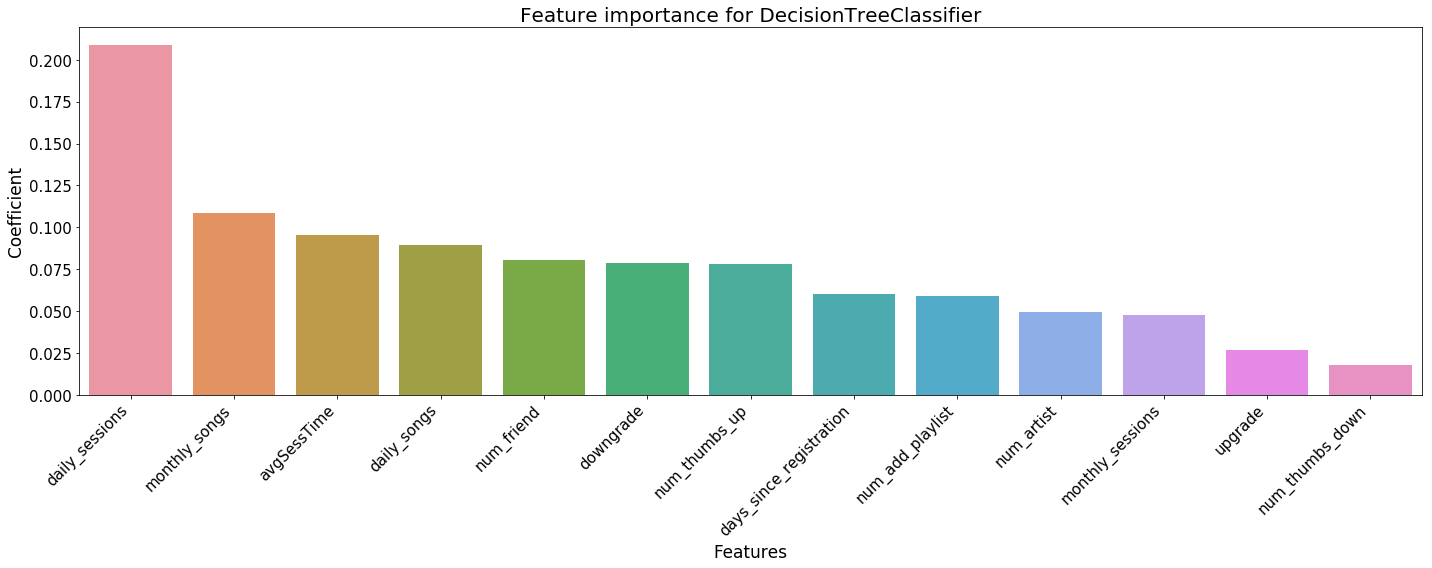

Training & tuning RandomForestClassifier model 
Evaluation result:
+---------+------+------+--------+
|precision|recall|    f1|accuracy|
+---------+------+------+--------+
|   0.8608|0.8308|0.7843|  0.8308|
+---------+------+------+--------+

Training time : 0.88 minutes


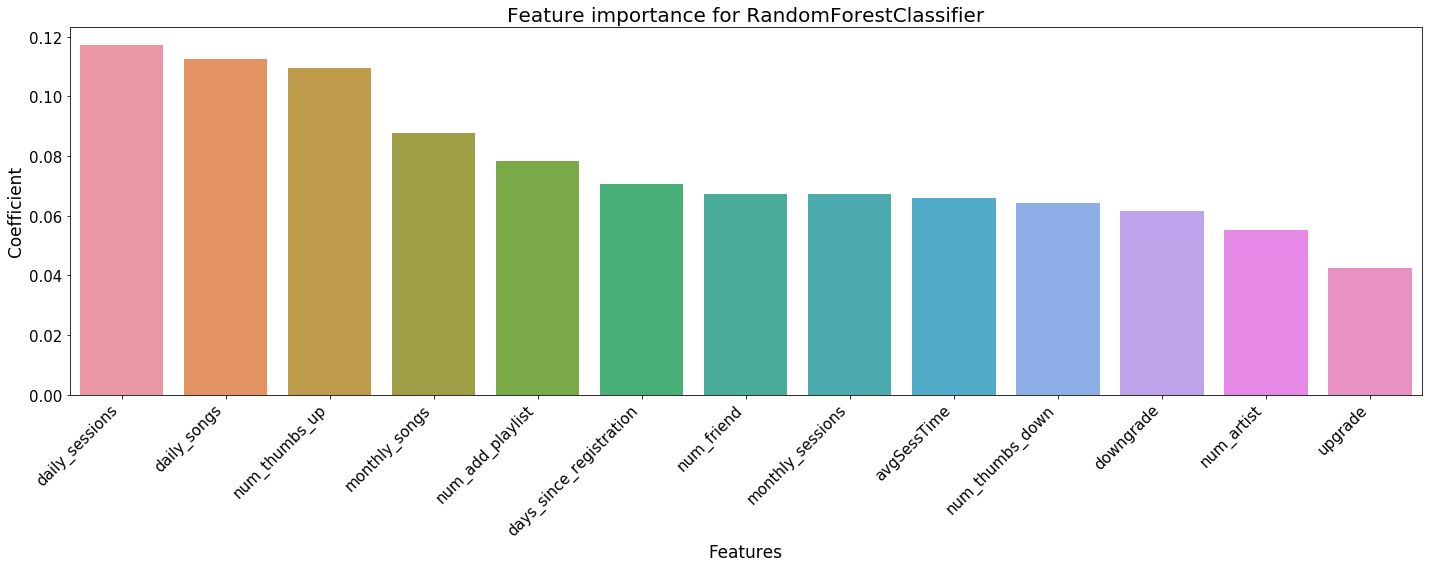

In [269]:
for i, est in enumerate(estimators):
    
    if i in [0, 2]: continue
        
    print("{}".format("="*91))
    start = time()

    print("Training & tuning {} model ".format(estimator_name[i]))
    model_n = train_model(train, est, paramGrids[i])
    summary_n = eval_model(model_n, test)

    print("Evaluation result:")
    summary_n.show()

    end = time()

    print('Training time : {} minutes'.format(round((end - start)/60, 2)))
    model_n.bestModel.write().overwrite().save('./Models/'+estimator_name[i])
    best_model_n = estimator_model[i].load('./Models/'+estimator_name[i])
    plot_feature_importance(best_model_n, numericCols+cat_cols, estimator_name[i])

    print("{}".format("="*91))

##### Observations

| Model | Feature 1 | Feature 2 | Feature 3 |
| :-: | :-: | :-: | :-: |
| Logistic |  |  |  |
| Decision Tree |  |  |  |
| Gradient-Boosted Tree |  |  |  |
| Random Forest |  |  |  | 

From the feature importance rankings above, we see that there are certain features that consistently show up as important, such as Daily number of session, Number of artists. At this moment, we cannot come up with a valuation for each of these features, but further work can be done to explore the effects of these features on churn retention. For instance, we might postulate that pushing for features that expose users to more artists might serve well in preventing users from leaving the platform. 

### 4.3 Model Diagnostics

##### ROC (Receiver Operating Characteristic)
$$\text{TPR} = \frac{TP}{TP+FN}$$

$$\text{FPR} = \frac{FP}{FP+TN}$$

ROC is a plot of $TPR$ against $FPR$ for various threshold values. Skillful models are represented by curves that bow up to the top left of the plot. A no skill classifier cannot discriminate between classes and is represented by the diagonal line from bottom left to top right with AUC of 0.5.

##### Precision
Precision can be understood as answerinf the following question: **What proportion of positive identifications was actually correct?**
$$\text{Recall} = \frac{TP}{TP+FP}$$

##### Recall
Recall can be understood as answering the following questions: **What proportion of actual positives was identified correctly?**
$$\text{Recall} = \frac{TP}{TP+FN}$$

Since, precision and recall are naturally in tension, we take a look at the **Precision-Recall curve** to jointly evaluate our model on these two metrics. The reason why we are particularly interested in jointly observing precision and recall is because we have a case of class imbalance here. Given our business objective to identify churn users, we are lessinterested in predicting the non-churn than we are in predicting the churn. 

A model with perfect skills is represented by a curve that bows toward (1,1). 

We also look at the AUC, which sumamrizes the skill of the model across various thresholds.

A no-skill classifier cannot discriminate between classes and would predict random or constant class, and changes based on the distribution of classes. 

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
ax = ax.ravel()

roc_auc_values = list()
precision_recall_auc_values = list()

for i, est in enumerate(estimators):
    
    best_model_n = estimator_model[i].load('./Models/'+estimator_name[i])
    temp = best_model_n.transform(final_dataset).select('label', 'probability').toPandas()
    temp['probability'] = temp['probability'].apply(lambda x: x[1])
    roc_auc_values.append(round(roc_auc_score(temp['label'], temp['probability']), 3))
    fpr, tpr, _ = roc_curve(temp['label'], temp['probability'])
    ax[0].plot(fpr, tpr, label=estimator_name[i]+' ({})'.format(str(roc_auc_values[i])))
    
    precision, recall, _ = precision_recall_curve(temp['label'], temp['probability'])
    auc_score = auc(recall, precision)
    precision_recall_auc_values.append(round(auc_score, 3))
    ax[1].plot(recall, precision, label=estimator_name[i]+' ({})'.format(str(precision_recall_auc_values[i])))
    
ax[0].set_title('ROC Curve')
ax[1].set_title('Precision-Recall Curve')
ax[0].legend()
ax[1].legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

## 5. Value Proposition <a id="value">
[back to top](#top)

To better understand the value of the above analysis, we make certain assumptions about the business model of Sparkify in order to identify how these churn identifications potentially increase the revenues of the platform. 

### 5.1 Final Models

In [ ]:
data_for_eval = final_dataset

best_LRClassifier = estimator_model[0].load('./Models/'+estimator_name[0])
results_LR = best_LRClassifier.transform(data_for_eval).select('label', 'prediction').toPandas()

best_DTClassifier = estimator_model[1].load('./Models/'+estimator_name[1])
results_DT = best_DTClassifier.transform(data_for_eval).select('label', 'prediction').toPandas()

best_GBTClassifier = estimator_model[2].load('./Models/'+estimator_name[2])
results_GBT = best_GBTClassifier.transform(data_for_eval).select('label', 'prediction').toPandas()

best_RFClassifier = estimator_model[3].load('./Models/'+estimator_name[3])
results_RF = best_RFClassifier.transform(data_for_eval).select('label', 'prediction').toPandas()


### 5.2 Confusion Matrices

In [ ]:
def plot_confusion(results):
    """
    Produces well-formatted confusion matrix

    Parameters
    ----------
    results : pd.DataFrame
        results containing the actual and predicted probabilities

    """
    cf_matrix = confusion_matrix(results['label'], results['prediction'])
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]

    labels = [f'{v1}\n{v2}' for v1, v2 in
              zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels,  annot_kws={"fontsize":20}, fmt='', cmap='Blues', cbar=False,
               xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [ ]:
print('='*30)
print('LR Results:')
print('='*30)
plot_confusion(results_LR)

print('='*30)
print('DT Results:')
print('='*30)
plot_confusion(results_DT)

print('='*30)
print('GBT Results:')
print('='*30)
plot_confusion(results_GBT)

print('='*30)
print('RF Results:')
print('='*30)
plot_confusion(results_RF)

**Interpretation**

For every $100$ customers who will cancel in the future, we can identify 88 of them beforehand. 